In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
from keras import models, layers
from yellowbrick.features import PCA
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data

In [2]:
#load data
train = pd.read_csv("train.csv")
test_raw_X = pd.read_csv("test.csv")
test_Y = pd.read_csv("sample_submission.csv")["SalePrice"].to_numpy().flatten()
train_raw_X = train.loc[:,train.columns!='SalePrice']
train_Y = train.loc[:,train.columns=='SalePrice'].to_numpy().flatten()
#temporarily merge for preprocessing
data = pd.concat([train_raw_X, test_raw_X])
#hard to handle, nonsense => dropped
data = data[[col for col in data.columns if col not in ['LotFrontage','GarageYrBlt', 'MoSold']]]

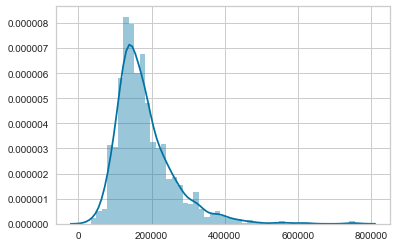

In [3]:
# distribution of label of training data
sns.distplot(train_Y)

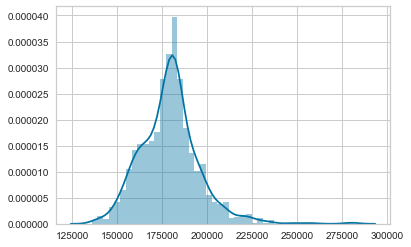

In [4]:
# distribution of label of test data
sns.distplot(test_Y)

## Discretize data

In [5]:
#data_Y = np.concatenate((train_Y, test_Y), axis=0)
#qt1 = np.percentile(data_Y, 33)
#qt2 = np.percentile(data_Y, 67)

In [6]:
#train_Y = pd.qcut(train_Y, 3, labels=[0, 1, 2])

In [7]:
qt1 = np.percentile(train_Y, 33)
qt2 = np.percentile(train_Y, 67)

In [8]:
for n, i in enumerate(train_Y):
    if i <= qt1:
        train_Y[n] = 0
    elif i >= qt2:
        train_Y[n] = 2
    else:
        train_Y[n] = 1
for n, i in enumerate(test_Y):
    if i <= qt1:
        test_Y[n] = 0
    elif i >= qt2:
        test_Y[n] = 2
    else:
        test_Y[n] = 1
test_Y = test_Y.astype(int)

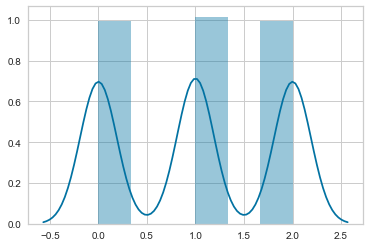

In [9]:
sns.distplot(train_Y)

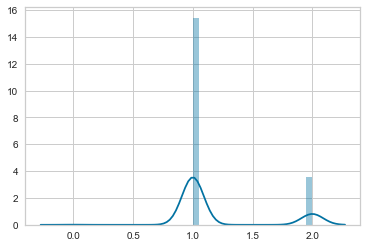

In [10]:
sns.distplot(test_Y)

## Preprocessing

In [11]:
#bsmt: 1 missing data
data["BsmtFinSF1"] = data["BsmtFinSF1"].replace(np.nan, 0)
data["BsmtFinSF2"] = data["BsmtFinSF2"].replace(np.nan, 0)
data["BsmtUnfSF"] = data["BsmtUnfSF"].replace(np.nan, 0)
data["TotalBsmtSF"] = data["TotalBsmtSF"].replace(np.nan, 0)
#bsmt bath: 2 missing data
data["BsmtFullBath"] = data["BsmtFinSF1"].replace(np.nan, 0)
data["BsmtHalfBath"] = data["BsmtFinSF2"].replace(np.nan, 0)
#garage: 1 missing data
data["GarageCars"] = data["GarageCars"].replace(np.nan, 0)
data["GarageArea"] = data["GarageArea"].replace(np.nan, 0)
# sorted categorical features to numerical
data["ExterQual"] = data["ExterQual"].replace({"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0})
data["ExterCond"] = data["ExterCond"].replace({"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0})
data["BsmtQual"] = data["BsmtQual"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0})
data["BsmtCond"] = data["BsmtCond"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0})
data["BsmtExposure"] = data["BsmtExposure"].replace({"Gd":4, "Av":3, "Mn":2, "No":1, np.nan:0})
data["BsmtFinType1"] = data["BsmtFinType1"].replace({"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,np.nan:0})
data["BsmtFinType2"] = data["BsmtFinType2"].replace({"GLQ":6,"ALQ":5,"BLQ":4,"Rec":3,"LwQ":2,"Unf":1,np.nan:0})
data["HeatingQC"] = data["HeatingQC"].replace({"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0})
data["CentralAir"] = data["CentralAir"].replace({"Y":1, "N":0})
data["KitchenQual"] = data["KitchenQual"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:3})
data["Functional"] = data["Functional"].replace({"Typ":7, "Min1":6, "Min2":5, "Mod":4, "Maj1":3, "Maj2":2,
                                                  "Sev":1, "Sal":0, np.nan:7})
data["FireplaceQu"] = data["FireplaceQu"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0})
data["GarageFinish"] = data["GarageFinish"].replace({"Fin":3, "RFn":2, "Unf":1, np.nan:0})
data["GarageQual"] = data["GarageQual"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0})
data["GarageCond"] = data["GarageCond"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0})
data["PavedDrive"] = train["PavedDrive"].replace({"Y":3, "P":2, "N":1, np.nan:0})
data["PoolQC"] = data["PoolQC"].replace({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0})
data["Fence"] = data["Fence"].replace({"GdPrv":4, "MnPrv":3, "GdWo":2, "MnWw":1, np.nan:0})
# fill NaN for categorical data (non-sorted)
#data["LotFrontage"] = data["LotFrontage"].replace(np.nan, 0) # I removed it
data["Alley"] = data["Alley"].replace(np.nan, "None")
data["MasVnrType"] = data["MasVnrType"].replace(np.nan, "None")
data["MasVnrArea"] = data["MasVnrArea"].replace(np.nan, 0)
data["Electrical"] = data["Electrical"].replace(np.nan, "SBrkr")
data["FireplaceQu"] = data["FireplaceQu"].replace(np.nan, "None")
data["GarageType"] = data["GarageType"].replace(np.nan, "None")
data["MiscFeature"] = data["MiscFeature"].replace(np.nan, "None")
# one-hot encoding for categorical data (non-sorted)
data = pd.get_dummies(
    data, prefix=['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','BldgType','MasVnrType'
                  'HouseStyle','LandSlope','Neighborhood','Condition1','Condition2','RoofStyle','RoofMatl',
                  'Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','GarageType',
                  'MiscFeature','SaleType','SaleCondition'], drop_first=True)

In [12]:
##feature selection & data split
#thresholder = VarianceThreshold(threshold=.2)
#data_hi_var = thresholder.fit_transform(data.loc[:,data.columns!='Id'])
data_hi_var = data.loc[:,data.columns!='Id']
train_X = data_hi_var[:1460]
test_X = data_hi_var[1460:]

## After Preprocessing: visualization with PCA

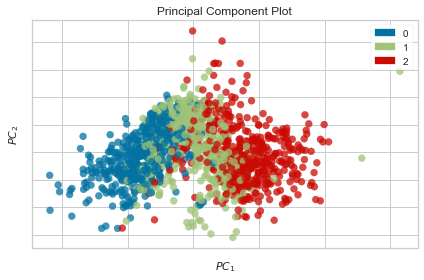

In [13]:
visualizer = PCA(scale=True, classes=[0,1,2])
visualizer.fit_transform(train_X, train_Y)
visualizer.show()

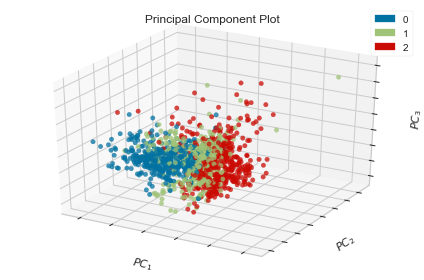

In [14]:
visualizer = PCA(scale=True, projection=3, classes=[0,1,2])
visualizer.fit_transform(train_X, train_Y)
visualizer.show()

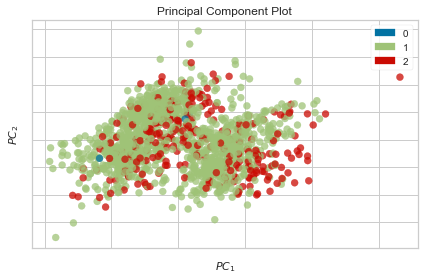

In [15]:
visualizer = PCA(scale=True, classes=[0,1,2])
visualizer.fit_transform(test_X, test_Y)
visualizer.show()

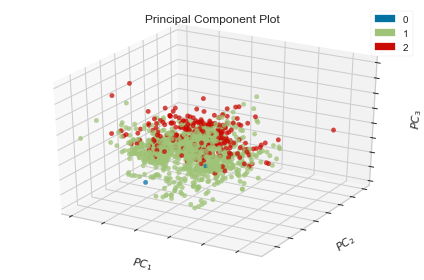

In [16]:
visualizer = PCA(scale=True, projection=3, classes=[0,1,2])
visualizer.fit_transform(test_X, test_Y)
visualizer.show()

In [17]:
#standardizer = StandardScaler()
#standardizer.fit(train_X)
#train_X = standardizer.transform(train_X)
#test_X = standardizer.transform(test_X)

In [18]:
def confusion_matrix_report(y_pred, y_test):
    con_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(con_matrix, ("low", "medium", "high"), ("low", "medium", "high"))
    heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
    bottom, top = heatmap.get_ylim()
    heatmap.set_ylim(bottom + 0.5, top - 0.5)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predict', fontsize=14)
    print(classification_report(y_test, y_pred))

In [19]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=1)

## Logistic Regression

In [20]:
logreg = LogisticRegression()
clf = logreg.fit(train_X,train_Y)
print("training score:\t", clf.score(train_X,train_Y))
print("test score:\t", clf.score(test_X,test_Y))

training score:	 0.7486301369863013
test score:	 0.3995887594242632


## Naive Bayes (Bernoulli)

In [21]:
nb = BernoulliNB()
clf = nb.fit(train_X,train_Y)
print("training score:\t", clf.score(train_X,train_Y))
print("test score:\t", clf.score(test_X,test_Y))

training score:	 0.7212328767123287
test score:	 0.3447566826593557


              precision    recall  f1-score   support

           0       0.79      0.76      0.78       483
           1       0.61      0.61      0.61       494
           2       0.76      0.80      0.78       483

    accuracy                           0.72      1460
   macro avg       0.72      0.72      0.72      1460
weighted avg       0.72      0.72      0.72      1460



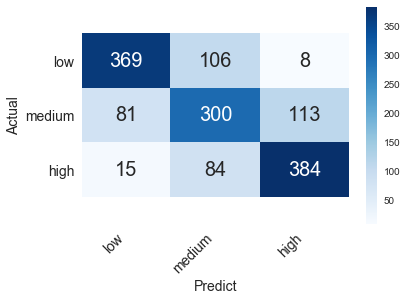

In [22]:
# confusion matrix - train
train_Ypred = clf.predict(train_X)
accuracy_score(train_Y, train_Ypred)
confusion_matrix_report(train_Ypred, train_Y)

              precision    recall  f1-score   support

           0       0.00      0.33      0.00         3
           1       0.81      0.33      0.47      1185
           2       0.22      0.40      0.29       271

    accuracy                           0.34      1459
   macro avg       0.35      0.35      0.25      1459
weighted avg       0.70      0.34      0.44      1459



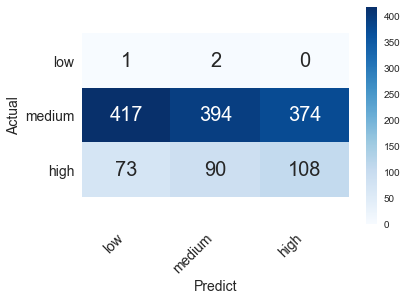

In [23]:
# confusion matrix - test
test_Ypred = clf.predict(test_X)
accuracy_score(test_Y, test_Ypred)
confusion_matrix_report(test_Ypred, test_Y)

## Naive Bayes (ComplementNB)

In [29]:
nb = ComplementNB()
clf = nb.fit(train_X,train_Y)
print("training score:\t", clf.score(train_X,train_Y))
print("test score:\t", clf.score(test_X,test_Y))

training score:	 0.5698630136986301
test score:	 0.1768334475668266


              precision    recall  f1-score   support

           0       0.54      0.87      0.66       483
           1       0.48      0.06      0.11       494
           2       0.62      0.79      0.70       483

    accuracy                           0.57      1460
   macro avg       0.55      0.57      0.49      1460
weighted avg       0.54      0.57      0.49      1460



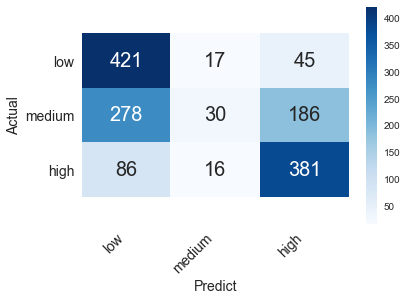

In [30]:
# confusion matrix - train
train_Ypred = clf.predict(train_X)
accuracy_score(train_Y, train_Ypred)
confusion_matrix_report(train_Ypred, train_Y)

              precision    recall  f1-score   support

           0       0.00      1.00      0.01         3
           1       0.82      0.05      0.09      1185
           2       0.35      0.72      0.47       271

    accuracy                           0.18      1459
   macro avg       0.39      0.59      0.19      1459
weighted avg       0.73      0.18      0.16      1459



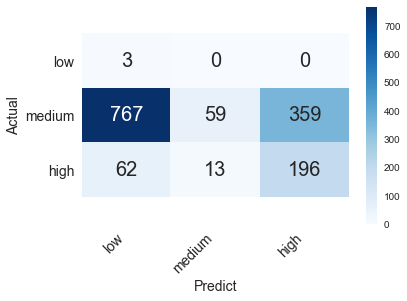

In [31]:
# confusion matrix - test
test_Ypred = clf.predict(test_X)
accuracy_score(test_Y, test_Ypred)
confusion_matrix_report(test_Ypred, test_Y)

## Naive Bayes (GaussianNB)

In [24]:
nb = GaussianNB()
clf = nb.fit(train_X,train_Y)
print("training score:\t", clf.score(train_X,train_Y))
print("test score:\t", clf.score(test_X,test_Y))

training score:	 0.773972602739726
test score:	 0.2700479780671693


              precision    recall  f1-score   support

           0       0.77      0.92      0.84       483
           1       0.73      0.55      0.63       494
           2       0.81      0.85      0.83       483

    accuracy                           0.77      1460
   macro avg       0.77      0.78      0.77      1460
weighted avg       0.77      0.77      0.77      1460



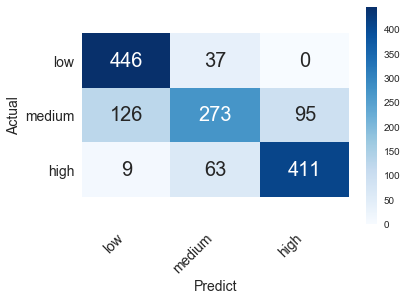

In [25]:
# confusion matrix - train
train_Ypred = clf.predict(train_X)
accuracy_score(train_Y, train_Ypred)
confusion_matrix_report(train_Ypred, train_Y)

In [ ]:
# confusion matrix - test
test_Ypred = clf.predict(test_X)
accuracy_score(test_Y, test_Ypred)
confusion_matrix_report(test_Ypred, test_Y)

## Naive Bayes (Multinomial)

In [32]:
nb = MultinomialNB()
clf = nb.fit(train_X,train_Y)
print("training score:\t", clf.score(train_X,train_Y))
print("test score:\t", clf.score(test_X,test_Y))

training score:	 0.613013698630137
test score:	 0.39547635366689515


              precision    recall  f1-score   support

           0       0.61      0.75      0.67       483
           1       0.51      0.40      0.45       494
           2       0.71      0.69      0.70       483

    accuracy                           0.61      1460
   macro avg       0.61      0.61      0.61      1460
weighted avg       0.61      0.61      0.61      1460



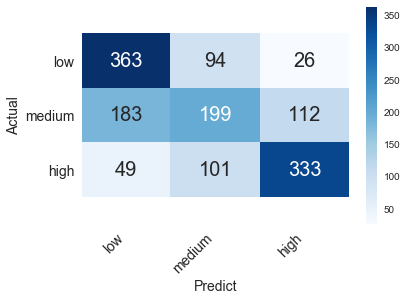

In [33]:
# confusion matrix - train
train_Ypred = clf.predict(train_X)
accuracy_score(train_Y, train_Ypred)
confusion_matrix_report(train_Ypred, train_Y)

              precision    recall  f1-score   support

           0       0.00      1.00      0.01         3
           1       0.89      0.34      0.49      1185
           2       0.44      0.64      0.52       271

    accuracy                           0.40      1459
   macro avg       0.45      0.66      0.34      1459
weighted avg       0.81      0.40      0.50      1459



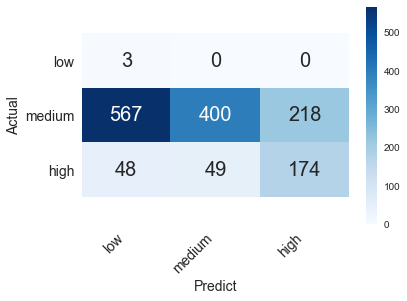

In [34]:
# confusion matrix - test
test_Ypred = clf.predict(test_X)
accuracy_score(test_Y, test_Ypred)
confusion_matrix_report(test_Ypred, test_Y)